# PROJETO 1 - CLASSIFICADOR DE SENTIMENTO DO FILME JOKER
__________________________________________________________________________________________________________________

### Alunos:

Nome: Beatriz Cabral Fernandes 

Nome: Eduardo Ancona Mateus 


## 1. INTRODUÇÃO 

A proposta desse projeto é desenvolver um classificador que irá analisar como o público está reagindo ao premiado filme ***Joker***, do diretor *Todd Phillips*. Para isso, será utilizado como método o famoso algoritmo de Naive-Bayes.

## 2. DESENVOLVIMENTO E METODOLOGIA

A fim de simplificar a explicação do processo de desenvolvimento do projeto, ele será dividido em X etapas

### ETAPA 1 - Preparando o ambiente no Jupyter

Nessa etapa, serão baixadas e importadas todas as bibliotecas relevantes para o código, bem como implementadas todas as funções a serem utilizadas

In [1]:
%%capture

#Instalando o tweepy
!pip install tweepy

#Importando as bibliotecas
import tweepy
import math
import os.path
import pandas as pd
import json
from random import shuffle
from IPython.display import Image
import re
import matplotlib.pyplot as plt 
import numpy as np

#criando funcao de limpeza de caracteres
def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[! - . : ? ; / https rt]' # Note que os sinais [] são delimitadores de um conjunto.
    
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, ' ', text)
    return text_subbed

### ETAPA 2 - Autenticando no Twitter

Conta: `@datascience_dudle`


Aqui será feita a autenticação no twitter, a partir de um código obtido no próprio site. Apenas o detentor das chaves de acesso da conta no Twitter consegue rodar o cógigo, e por isso ele encontra-se comentado.

In [2]:
#leitura do arquivo no formato JSON
#with open('auth.pass') as fp:    
    
    #data = json.load(fp)

#Configurando a biblioteca. Não modificar
#auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
#auth.set_access_token(data['access_token'], data['access_token_secret'])

____________

### ETAPA 3 - Escolha de um produto e coleta das mensagens

No arquivo `Projeto1_Obtenção_dos_tweets.ipynb` foram coletados tweets relacionados ao filme ***Joker*** e salvos em na planilha do excel `Joker.xlsx`. Ao coletar os tweets com essa keyword, obtivemos 601 tweets para treinamento e 600 para teste. Em seguida foi feita a leitura dos arquivos.

In [3]:
# Fazendo a leitura da planilha de treinamento
excel = pd.read_excel('Joker.xlsx', sheet_name='Treinamento')
excel_teste = pd.read_excel('Joker.xlsx', sheet_name='Teste')
#excel_teste.rename(columns={'Etiquetas':'Class_manual'}, inplace=True) 

In [4]:
excel_teste.head()

,Treinamento,Etiquetas
0,rt @_dcbrasil: maior ato do cinema de 2019! \n...,1
1,eu ñ fui assistir joker no cinema aqui pq so t...,3
2,@dracoh8 @caiquecerq @mateuscrz098 @joker_bsa ...,5
3,@joker_bsa @mitofaztd @portalprior mas o prior...,5
4,rt @itzguk: kpopper atacando o bts por tudo e ...,5


### ETAPA 4 - Classificação manual dos tweets

Vale ressaltar que o foco desse estudo é analisar o sentimento dos tweets relacionados ao premiado filme ***Joker***.
Desta forma, foram previamente estabelecidas 5 categorias para a classificação das mensagens:

* `P` - ***Crítica positiva*** – se a mensagem transmitida é uma crítica positiva;
* `N` - ***Crítica negativa*** – se a mensagem transmitida é uma crítica negativa;
* `I` - ***Irrelevante*** – se a mensagem transmitida estiver no contexto proposto, mas não for relevante para análise;
* `R` - ***Reação*** - se a mensagem transmitida trata-se de uma reação ou emoção em relação ao filme ou a uma cena;
* `F` - ***Fora do contexto*** - se a mensagem transmitida esta fora do contexto proposto.


Estabelecidas as categorias e selecionados os tweets, foi utilizada a base de treinamento, na qual as mensagens foram qualificadas manualmente no excel de acordo com a categoria mais adequada. Conforme mostra a tabela a seguir:

In [5]:
excel.loc[:,'Etiquetas'] = excel['Etiquetas'].astype('category')
excel.Etiquetas.cat.categories = ['P','N','I','R','F']
excel = excel.apply(pd.Series.replace, to_replace=['P','N','I', 'R'] , value='D')
excel.head()

,Treinamento,Etiquetas
0,mortos pelo regime genocida da china 100.000.0...,F
1,"@thiago_joker tempos de quarentena, sei lá né ...",F
2,se o governador do rio de janeiro candidatar p...,F
3,@jillajeeva332 @yutheesh0011 @joker_rowdy @pok...,F
4,galera só pra relembrar os filmes da dc de mai...,D


### ETAPA 5 - Montando o Classificador Naive-Bayes

### Breve explicação de *Naive Bayes*
O algoritmo de *Naive Bayes* é um classificador probabilístico baseado no teorema de Bayes, utilizado no processo de machine learning. O algoritmo supõe que uma característica independe da outra para acontecer, ou seja, mesmo na presença de uma característica particular em uma classe, isso não afeta na probabilidade de qualquer característica ocorrer. O teorema de bayes é escrito da seguinte forma:

![title](img/bayes.png)

* $P(A)$ - Probabilidade a priori
* $P(B)$ - Probilidade Total
* $P(A|B)$ - posteriori
* $P(B|A)$ - verossimilhanca


Esse método será utilizado no projeto, uma vez que permite calcular a probabilidade de uma mensagem receber diferentes classificações, por exemplo, dado um tweet, assumindo que as palavras nele não tem nenhuma relação entre si.

A partir do nosso modelo, poderíamos reescrever o teorema de bayes da seguinte forma:

# $P(C|P) = \frac{P(P|C).P(C)}{P(P)}$

A variável C é a classe variável que representa a categoria de um tweet, a partir das condições estabelecidas (probabilidade de ocorrência de uma palavra dada as condições). A variável P representa as palavras ocorridas nos tweets.


P pode ser:

![title](img/bayes2.png)

Substituindo P por cada uma das possíveis palavras, temos:

![title](img/bayes3.png)

Nesse momento queremos classificar se um tweet está dentro ou fora do contexto do filme Joker. Para tanto é necessário analisar analisar as probabilidades.


Ou seja, precisa decidir se:

## $P(Dentro do contexto|frase) > P(Fora do contexto|frase)$



Utilizando o teorema de Bayes, temos:

## $P(D|frase) = \frac{P(frase|D)P(D)}{P(frase)}$

e que:

## $P(F|frase) = \frac{P(frase|F)P(F)}{P(frase)}$



Para implementar esse algoritmo, uma nova tabela deve ser criada com as palavras e suas respectivas frequências relativas em cada uma das categorias. Porém antes disso, deverá ser feita uma limpeza das mensagens, removendo pontuações e caracteres que não convém a análise.

In [6]:
# Verificando categorias do meu dataset
list(excel)

['Treinamento', 'Etiquetas']

In [26]:
# Juntando todos os tweets da base de treinamento
texto_completo = cleanup(' '.join(excel.Treinamento)).split()
palavras_total = pd.Series(texto_completo).value_counts()
palavras_total.head(15)

a       2247
e       1743
o       1693
de       476
i        447
joke     432
que      422
é        335
co       324
@        281
do       280
u        234
em       231
eu       219
en       197
dtype: int64

In [28]:
print('Número de palavras diferentes na base de treinamento inteira:', len(palavras_total))

Número de palavras diferentes na base de treinamento inteira: 4086


Fazendo uma breve análise dos 15 termos mais frequentes, observa-se que alguns desses termos não são significantes para a nossa análise, e portanto deve-se ser feita a limpeza para nao prejudicar o resultado/performance. Exemplo:
- https
- -
- rt
- /
- @

In [8]:
def Frequencia(n):
    y = cleanup(' '.join(excel[excel.Etiquetas==n].Treinamento)).split() #y é uma lista com todas as palavras de cada categoria
    f_rel = pd.Series(y).value_counts(True)
    f_abs = pd.Series(y).value_counts()
    prob = len(y)/len(texto_completo)
    return y,f_rel,f_abs,prob

### Definindo a probabilidade de cada uma das categorias

Observando a tabela a seguir, depreende-se que uma grande parte dos tweets fora do contexto do projeto. 

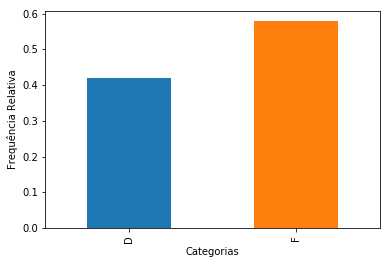

,Etiquetas
D,0.420417
F,0.579583


In [9]:
ct1 = pd.Series(excel.Etiquetas).value_counts(True).sort_index()
ct1.plot(kind='bar')
plt.ylabel('Frequência Relativa')
plt.xlabel('Categorias')
plt.show()
ct1.to_frame()

Dessa forma, como tambem para nao criar um classificador enviesado, vamos primeiro classificar os tweets em 2 principais categorias: como Dentro do contexto(soma das categorias P,N,R e I) ou Fora do contexto(categoria F).


Aqui, ainda utilizando a funcao anterior que além de limpar a base, retorna as frequencias de cada uma das categorias, podemos definir as seguintes probabilidades:

In [10]:
d, rel_d, abs_d, prob_d = Frequencia('D')
f, rel_f, abs_f, prob_f = Frequencia('F')

#Definindo as probabilidades: soma = 1
prob_f = len(f)/len(d + f)
rel_d.head(15)

a        0.088623
o        0.074505
e        0.072650
joke     0.030606
i        0.021538
de       0.019270
que      0.017209
co       0.014530
é        0.013603
do       0.013500
em       0.009584
eu       0.009171
en       0.009068
filme    0.007729
ma       0.007420
dtype: float64

In [29]:
print('Número de palavras diferentes na base de treinamento inteira:', len(rel_d+rel_f))

Número de palavras diferentes na base de treinamento inteira: 4086


In [32]:
def calcula_prob(n):
    alpha = 1
    y,f_rel,f_abs,prob = Frequencia(n)
    probTweetDadoN = []
    probNDadoTweet = []
    for t in excel_teste.Treinamento:
        PTweetDadoN = 1 #para funcionar o loop que vai multiplicar todas as prob de cada palavra dado a cat
        tweet = cleanup(t).split()
        num_pal_pos = len(f_abs) #numero de palavras possiveis na categoria n 
        num_pal_tot = len(rel_d+rel_f) #numero total de palavras na base de treinamento inteira
        for p in tweet:
            if p in f_rel:
                f_abs_cat = f_abs[p] # quantas vezes a palavra aparece no treino
            else: # se a palavra nao tiver na base de treino freq abs é igual a zero
                f_abs_cat = 0
            PPalavraDadoN = (alpha+f_abs_cat)/(num_pal_pos+num_pal_tot) #probabilidade da palavra dado a categoria #elevei a 2 para as probabilidades nao ficarem mt pequenas
            PTweetDadoN = PTweetDadoN * PPalavraDadoN
        PNDadoTweet = prob*PTweetDadoN
        probTweetDadoN.append(PTweetDadoN) #add a probabilidade de cada tweet dado determinada categoria. 
        probNDadoTweet.append(PNDadoTweet)#Como estamos analisando uma mesma coluna, o len da lista de ambas as categorias vai ser igual, é tranquilo fazer uma lista
    return probTweetDadoN, probNDadoTweet


In [35]:
probTweetDadoD, probDDadoTweet= calcula_prob('D')
probTweetDadoF, probFDadoTweet = calcula_prob('F')
probDDadoTweet, probFDadoTweet

([1.2694144337435482e-66,
  2.601754259199429e-102,
  9.253578824317623e-73,
  7.010046034186822e-137,
  1.9259347159641535e-53,
  2.1495417501884398e-17,
  3.919630472774013e-16,
  6.57993041438636e-39,
  5.374039903832912e-61,
  1.2124396334565013e-36,
  1.251273854884898e-47,
  1.2588158889859356e-44,
  1.189236566016579e-69,
  1.0600155317666027e-157,
  1.4337723780748432e-58,
  1.3130436953541962e-23,
  4.703569967774874e-13,
  1.0516231427282145e-46,
  2.806801806673292e-122,
  1.8239953475058288e-112,
  2.4466281824573527e-19,
  3.9976140652149586e-43,
  2.375461435468113e-47,
  5.2797101428969575e-87,
  1.4717579685726336e-37,
  1.5884945612865276e-41,
  9.423042106060871e-60,
  3.0862950505797454e-49,
  2.0966589448635506e-25,
  3.310440512564667e-42,
  3.384438067419839e-20,
  1.997773428941098e-68,
  2.933348401600142e-27,
  4.963478848188168e-48,
  1.3544167294241898e-147,
  4.3491916703862076e-163,
  2.4023553425996053e-57,
  6.036597612602828e-118,
  7.890490000997274e-27

tenho uma lista com a probabilidade de cada tweet pra cada categoria, logo probDDadoTweet[i] é correspondente a probFDadoTweet[i]



In [34]:
class_tweet = []
for i in range(len(probTweetDadoD)-1):
    if probDDadoTweet[i]>probFDadoTweet[i]:
        class_tweet.append('D')
    else:
        class_tweet.append('F')
    excel_teste['class_auto'] = class_tweet
    
class_tweet
    
#print("Probabilidade de Tweet dado que é dentro do contexto: ", probTweetDadoD)
#print("Probabilidade de Tweet dado que é fora do contexto: ", probTweetDadoF)
#print("Probabilidade de estar dentro do contexto dado que Tweet: ", probDDadoTweet)
#print("Probabilidade de estar fora do contexto dado que Tweet: ", probFDadoTweet)
#excel_teste.head()

ValueError: Length of values does not match length of index

# para criar uma nova coluna basta criar uma lista com os valores da classificacao automatica e depois `excel_teste["class_auto"]`

### ETAPA 6 - Verificando a performance do classificador

## CONCLUSÃO

- Faça um comparativo qualitativo sobre os percentuais obtidos para que possa discutir a performance do seu classificador.
- Explique como são tratadas as mensagens com dupla negação e sarcasmo.
- Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?


Opcionalmente:

- Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.

*Ao se utilizar o próprio classificador para gerar mais amostras de treinamento, o classificador acaba ficando 
'viciado', ou seja, acaba-se por prejudicar os resultados obtidos, e eles acabam não tendo uma qualidade boa.
Seria o contrário de puxar mais tweets, que melhora a qualidade dos dados e dos resultados, por ter um espaço 
amostral muito maior.*



- Propor diferentes cenários de uso para o classificador Naive-Bayes. Pense em outros cenários sem intersecção com este projeto.
- Sugerir e explicar melhorias reais no classificador com indicações concretas de como implementar (não é preciso codificar, mas indicar como fazer. Indique material de pesquisa sobre o assunto).